# Notebook d'exploration

Ce notebook contient le data cleaning, le préprocessing, l'analyse exploratoire, et les réductions dimentionnelles.

# Imports

## Librairies

In [ ]:
# Connecte le notebook Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import de librairies
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from bs4 import BeautifulSoup
from bs4 import UnicodeDammit


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from yellowbrick.text import FreqDistVisualizer

import unicodedata

In [ ]:
# Dictionnaire des contractions anglaises et leurs équivalents complets

"""
@author: DIP
"""

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
# Imports
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##Fonctions

Les fonctions suivantes proviennent de cet article:
https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [ ]:
nlp = spacy.load('en_core_web_sm')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def tok(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text)

def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Données

Les données sont les questions StackOverflow:
- ayant étés mises en favoris par au moins 6 utilisateurs
- ayant obtenues un score d'au moins 7
- ayant reçu au moins une réponse 
- ayant au moins 5 tags

Soit un total de **53750 questions StackOverflow**

In [ ]:
# Chargement des datasets
csv1573780 = pd.read_csv('drive/MyDrive/PStackOverflow/data/1573780.csv')
csv1573796 = pd.read_csv('drive/MyDrive/PStackOverflow/data/1573796.csv')

In [ ]:
# Concat les csv en un DataFrame
df = pd.concat([csv1573780, csv1573796])

# Nombre de questions SO
len(df)

53750

# Cleaning

## Pre-processing

In [ ]:
# Retire le code des questions
remove_code = lambda x: re.sub('<code>(.*?)</code>', ' ', x, flags=re.MULTILINE|re.DOTALL)

In [ ]:
# merge le titre et le post en un bloc de texte
df["Text"] = df["Title"] + df["Body"].apply(remove_code)

In [ ]:
# Preprocess les questions
df["cleaned_Text"] = normalize_corpus(df["Text"])

In [ ]:
# Check Titre de la question
df["Title"][27024]

"Database won't remove when uninstall the Android Application"

In [ ]:
# Check corps de la question
print(df["Body"][27024])

<p>I have two major questions. </p>

<ol>
<li>Database won't delete when uninstall app.</li>
<li>Downloaded files won't delete while unstable the app.</li>
</ol>

<p>There is a database in my android application. I create it by java</p>

<pre><code>class as follows.

public DataBaseHelper(Context context) {
    super(context, DATABASE_NAME, null, DATABASE_VERSION);
}

public DataBaseHelper(Context context, String name, SQLiteDatabase.CursorFactory factory, int version, DatabaseErrorHandler errorHandler) {
    super(context, name, factory, version, errorHandler);
}

@Override
public void onCreate(SQLiteDatabase db) {
    // creating required tables
    db.execSQL(CREATE_TABLE_QUOTES);
    db.execSQL(CREATE_TABLE_FILTERS);
}

@Override
public void onUpgrade(SQLiteDatabase db, int oldVersion, int newVersion) {
    // on upgrade drop older tables
    db.execSQL("DROP TABLE IF EXISTS " + TABLE_QUOTES);
    db.execSQL("DROP TABLE IF EXISTS " + TABLE_QUOTES);
    // create new tables
    onCr

In [ ]:
# Check du texte preprocessed
df["cleaned_Text"][27024]

'database remove uninstall android applicationi two major question database delete uninstall app downloaded file delete unstable app database android application create java specific path define code database code download file specific path allow create folder android datum com myapp well please help sorry bad english'

**QUID des var_name et autres func_names? impossible de différencier les noms de variables, les fonctions, etc... Garder? Supprimer?**

In [ ]:
# Preprocess les tags
df["cleaned_Tags"] = df["Tags"].str.lower() 
df["cleaned_Tags"] = df["cleaned_Tags"].replace({"><" : " "}, regex=True)
df["cleaned_Tags"] = df["cleaned_Tags"].replace({"<" : ""}, regex=True)
df["cleaned_Tags"] = df["cleaned_Tags"].replace({">" : ""}, regex=True)


In [ ]:
# Check
df["cleaned_Tags"][27024]

'android sqlite android-sqlite android-file android-database'

## Suppression des questions vides après pre-processing

In [ ]:
df[df["cleaned_Text"] == '']

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Text,cleaned_Text,cleaned_Tags


In [ ]:
df.drop(df[df["cleaned_Text"] == ''].index, inplace=True)

In [ ]:
df[df["cleaned_Text"] == ' ']

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Text,cleaned_Text,cleaned_Tags


In [ ]:
df[df["cleaned_Text"] == np.NaN]

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Text,cleaned_Text,cleaned_Tags


Il n'y a pas de questions après pré-traitement.

# Créations de variables quantitatives

In [ ]:
# Nombre de tokens après pre-processing
df["n_token"] = df["cleaned_Text"].str.count(' ') + 1

# Sauvegarde du dataset

In [ ]:
# Export en .csv
df.to_csv("drive/MyDrive/PStackOverflow/data/df_clean.csv", index=False)

In [ ]:
# Charge le dataset traité
df = pd.read_csv('drive/MyDrive/PStackOverflow/data/df_clean.csv')

# EDA

## Variables quantitatives

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Statistiques descriptives
df[['ViewCount', 'FavoriteCount', 'AnswerCount', 'n_token']].describe()

,ViewCount,FavoriteCount,AnswerCount,n_token
count,53750,53750,53750,53750
mean,67231,25,5,69
std,175777,109,5,63
min,141,6,1,1
25%,11055,7,2,33
50%,26280,11,4,52
75%,62908,19,7,84
max,9771619,11552,125,1643


### 'ViewCount'

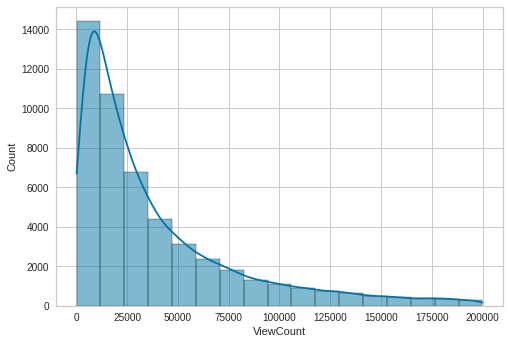

In [ ]:
# histogramme
sns.histplot(data=df[df['ViewCount'] < 200000], x='ViewCount', bins='sturges', kde=True)

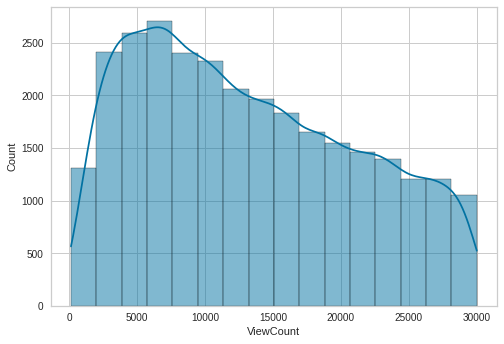

In [ ]:
# histogramme
sns.histplot(data=df[df['ViewCount'] < 30000], x='ViewCount', bins='sturges', kde=True)

### 'FavoriteCount'

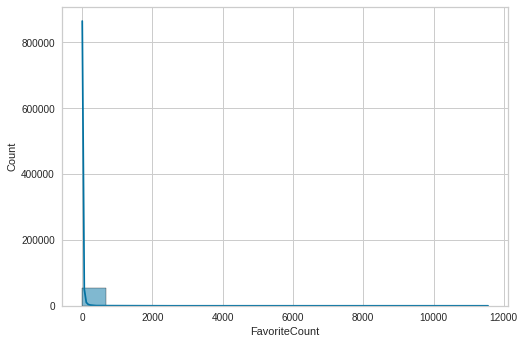

In [ ]:
# histogramme
sns.histplot(data=df, x='FavoriteCount', bins='sturges', kde=True)

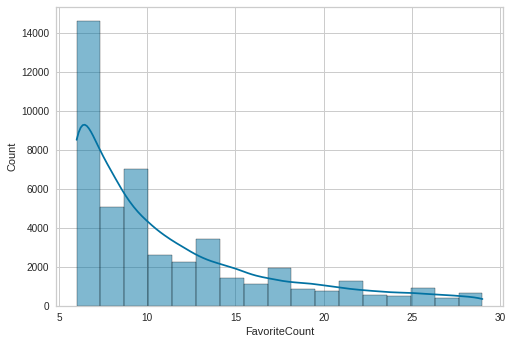

In [ ]:
# histogramme
sns.histplot(data=df[df['FavoriteCount'] < 30], x='FavoriteCount', bins='sturges', kde=True)

### 'AnswerCount'

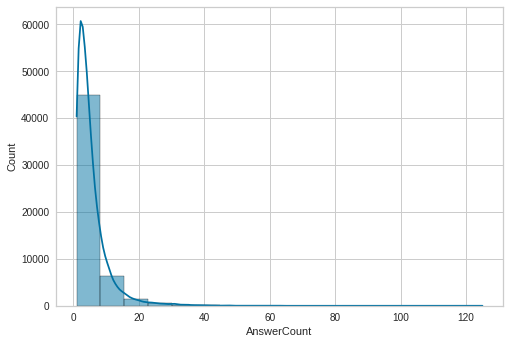

In [ ]:
# histogramme
sns.histplot(data=df[df['AnswerCount'] < 3000], x='AnswerCount', bins='sturges', kde=True)

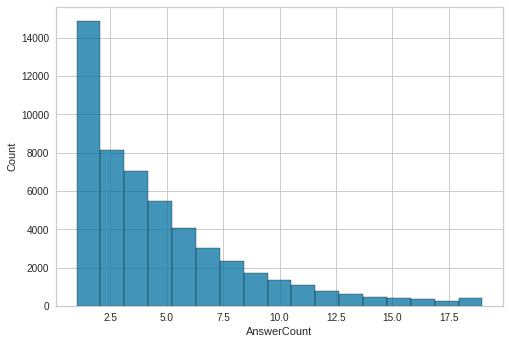

In [ ]:
# histogramme
sns.histplot(data=df[df['AnswerCount'] < 20], x='AnswerCount', bins='sturges', kde=False)

### 'n_token'

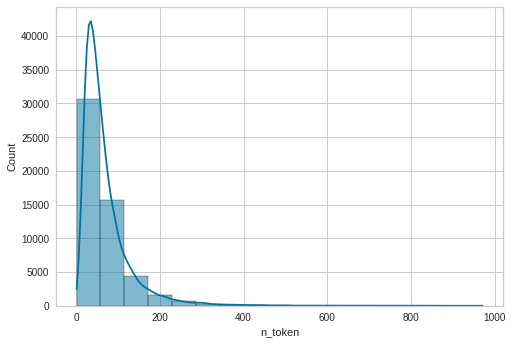

In [ ]:
# histogramme
sns.histplot(data=df[df['n_token'] < 1000], x='n_token', bins='sturges', kde=True)

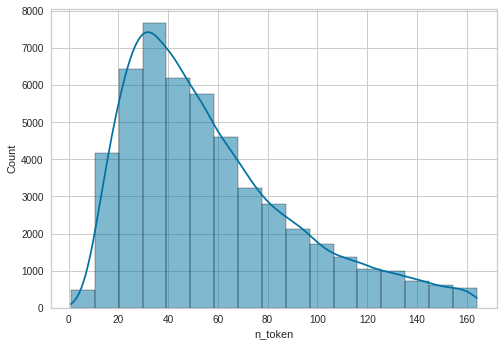

In [ ]:
# histogramme
sns.histplot(data=df[df['n_token'] < 165], x='n_token', bins='sturges', kde=True)

Toutes ces variables semblent suivre des distributions log-normales.

### Correlation heatmap

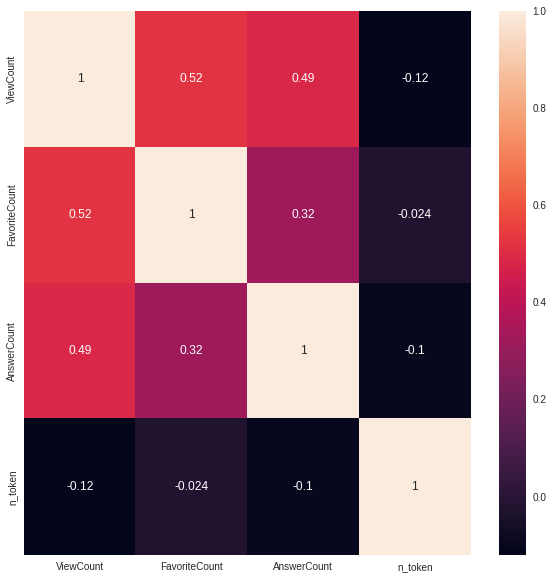

In [ ]:
# Correlation heatmap
corrMatrix = df[['ViewCount', 'FavoriteCount', 'AnswerCount', 'n_token']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

Il y a corrélation positive entre le nombre de favoris, le nombre de vue, et le nombre de réponses à une question.

Le nombre de tokens n'est pas corrélé aux autres variables.

## Tags

In [ ]:
# Bag of Words
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(df["cleaned_Tags"])
features = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


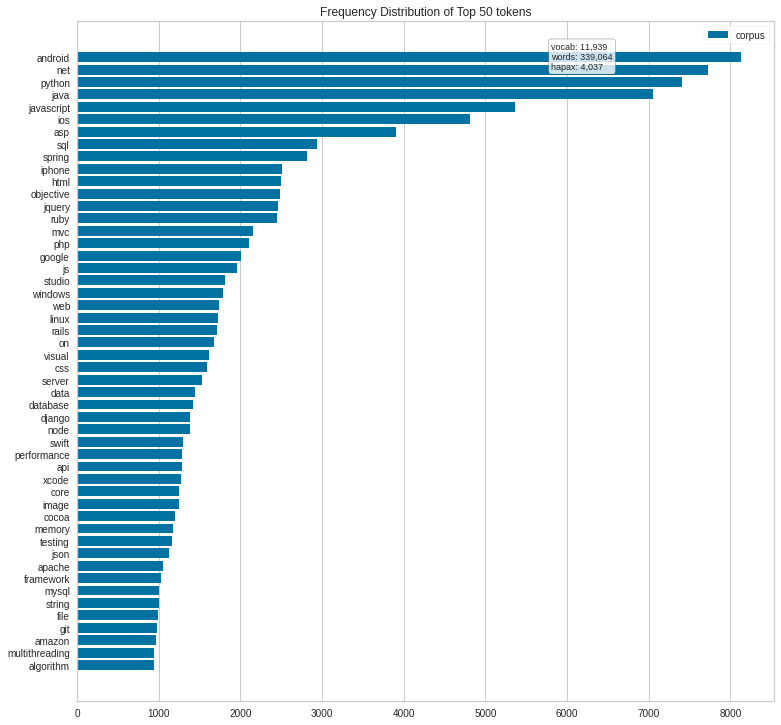

In [ ]:
# Hist des 50 tags les plus communs
visualizer = FreqDistVisualizer(features=features, orient='h', size=(900, 900))
visualizer.fit(docs)
visualizer.show()

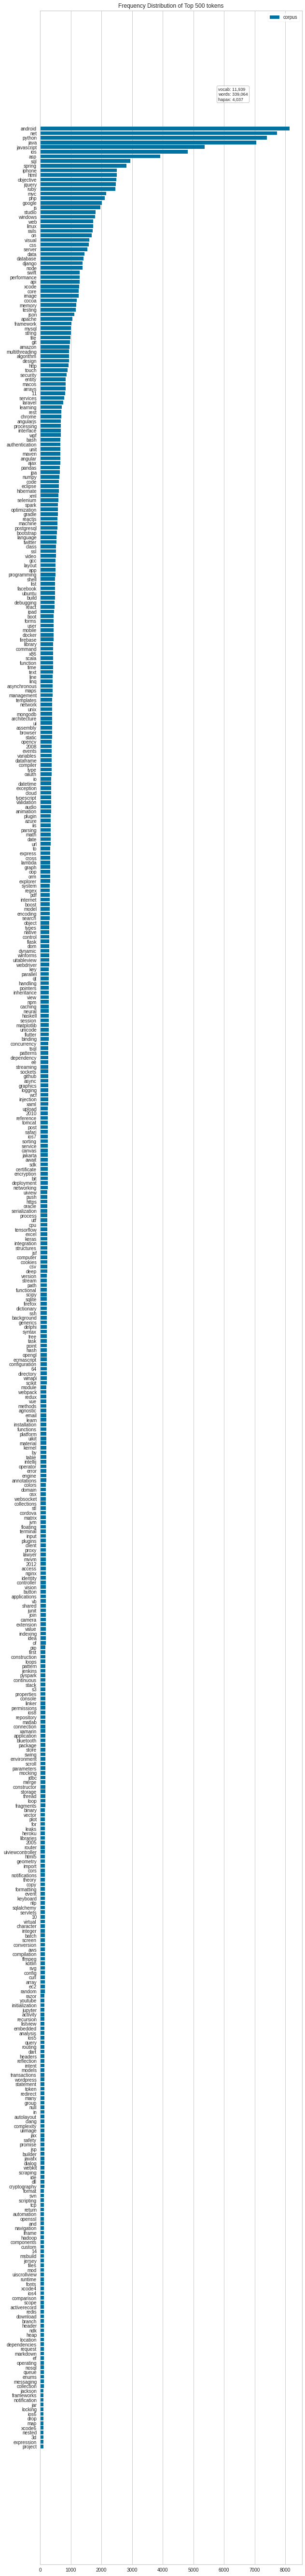

In [ ]:
# Hist des 500 tags les plus communs
visualizer = FreqDistVisualizer(features=features, n=500, orient='h', size=(700, 7000))
visualizer.fit(docs)
visualizer.show()

## Tokens des questions

In [ ]:
# Bag of Words
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(df["cleaned_Text"])
features = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


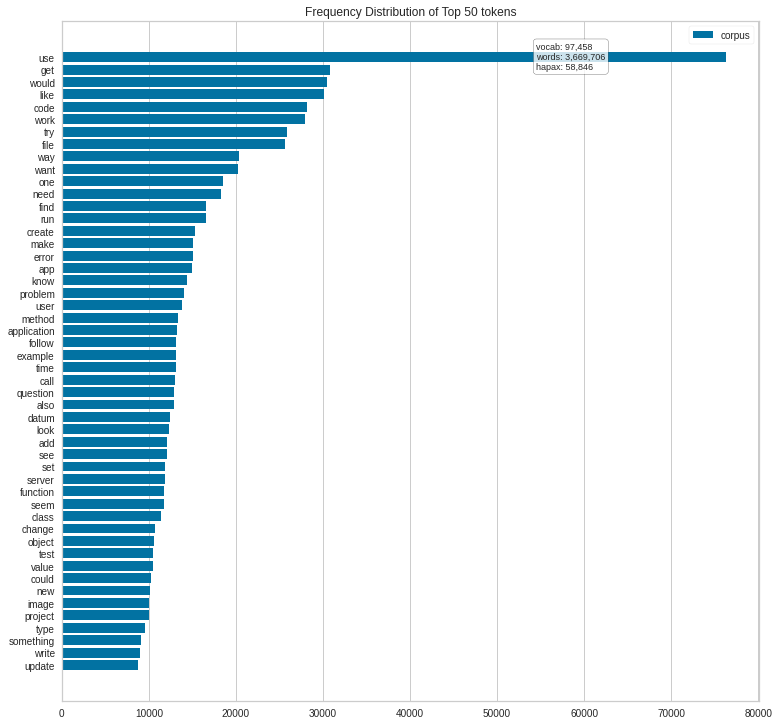

In [ ]:
# Hist des 50 tokens les plus communs
visualizer = FreqDistVisualizer(features=features, orient='h', size=(900, 900))
visualizer.fit(docs)
visualizer.show()

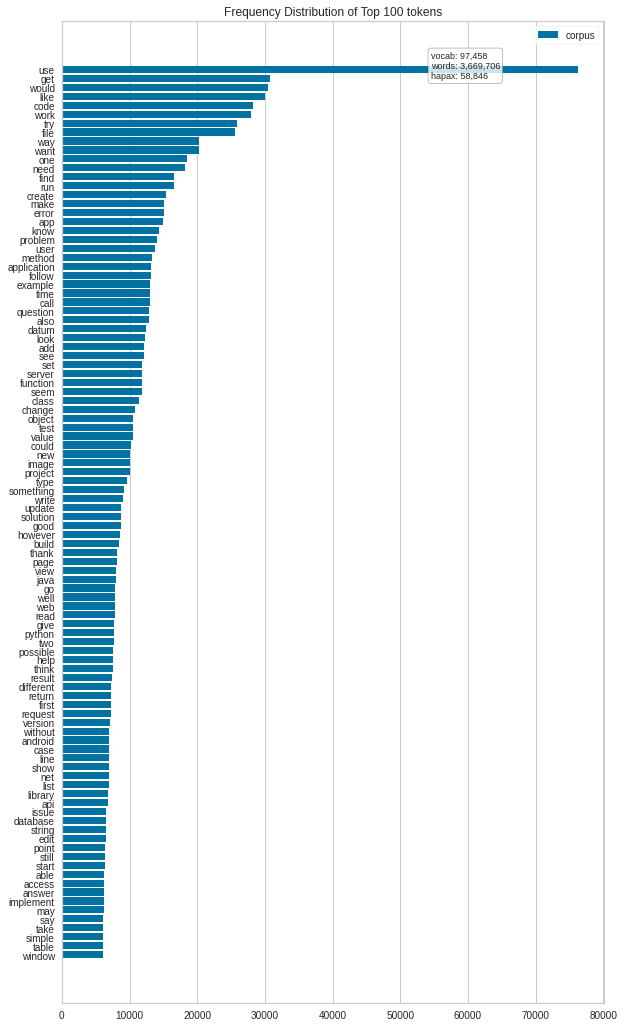

In [ ]:
# Hist des 100 tokens les plus communs
visualizer = FreqDistVisualizer(features=features, n=100, orient='h', size=(700, 1300))
visualizer.fit(docs)
visualizer.show()

# Réduction dimentionnelle

## TF-IDF

Nous allons appliquer nos méthodes de réduction dimentionnelle sur un TF-IDF:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(
    #max_features=2000
    )
X = vectorizer.fit_transform(df["cleaned_Text"])

## ACP

Application de l'ACP.

Le code et les fonctions sont issus du cours (version anglaise) OpenClassrooms sur le sujet.

In [ ]:
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
   
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# constitution du dataset pour l'ACP
df_acp = pd.DataFrame(data = X.toarray(),  
                      columns = list(vectorizer.get_feature_names_out()))

n_comp = 200
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

X = df_acp.values
features = df_acp.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

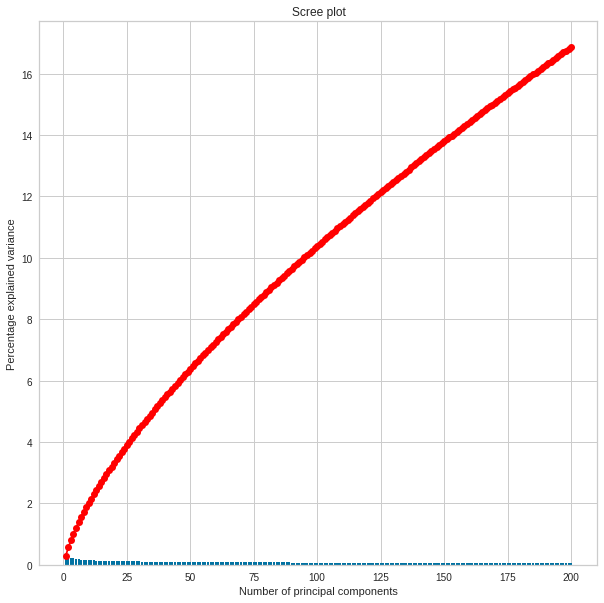

In [ ]:
plt.figure(figsize=(10, 10))
display_scree_plot(pca)

**Chaque composante capture une très faible part de la variance**, et la variance capturée par chaque nouvelle composante est de plus en plus faible.

<Figure size 1080x1080 with 0 Axes>

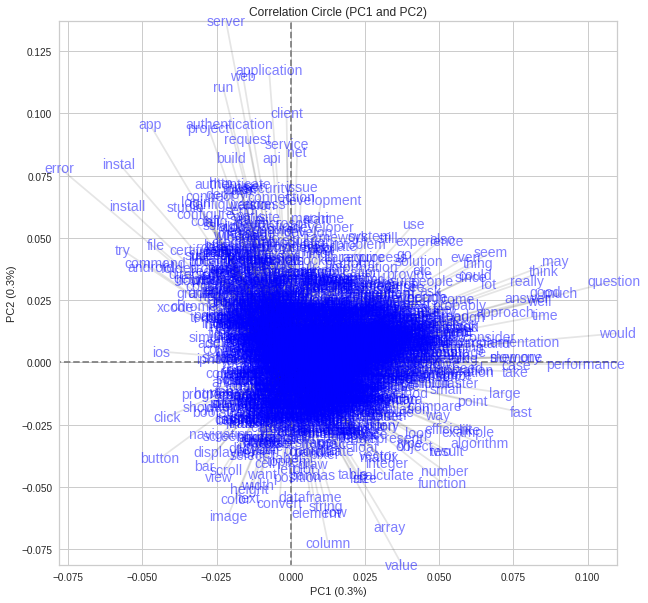

In [ ]:
# Cercle des corrélations PC1 x PC2
plt.figure(figsize=(15, 15))
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

<Figure size 1080x1080 with 0 Axes>

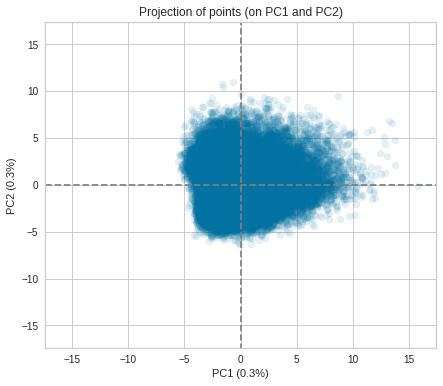

In [ ]:
# Projection dans le plans PC1 x PC2

# Transform the original scaled data to the new vector space
X_projected = pca.transform(X_scaled) 

# Display a scatter plot of the data points in this new vector space
plt.figure(figsize=(15, 15))
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], alpha = 0.1)
plt.show()

Text(0, 0.5, 'PC2')

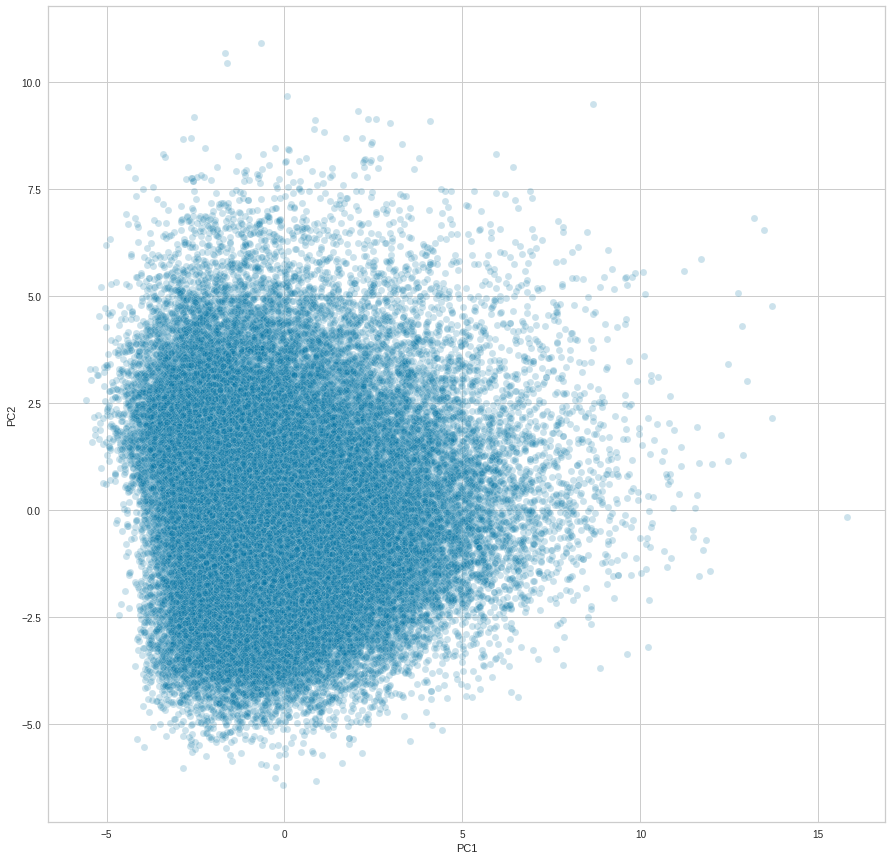

In [ ]:
# Plot en plus grand
X_p = pd.DataFrame(X_projected)

plt.figure(figsize = (15, 15))
sns.scatterplot(data = X_p,
               x = 0, 
               y = 1,
               alpha = 0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Au vu de la variance capturée, et des graphiques ci-dessus, **l'utilisation d'une ACP pour réduire les dimentions n'est pas concluante**.

##t-SNE

On applique le t-SNE sur un échantillon de 4000 observations pour limiter le temps de calcul et avoir un résultat lisibile.

In [ ]:
# préselection d'un échantillon avec seulement les observations ayant les tags analysés
#df_top_tags = df[df.Tags.str.contains('<java>|<python>|<c#>|<sql>', regex=True) == True]

In [ ]:
# marque les observations de chaque tag analysé
df["contain_java"] = np.where(df.Tags.str.contains('<java>', regex=True), 1, 0)
df["contain_python"] = np.where(df.Tags.str.contains('<python>', regex=True), 1, 0)
df["contain_csharp"] = np.where(df.Tags.str.contains('<c#>', regex=True), 1, 0)
df["contain_sql"] = np.where(df.Tags.str.contains('<sql>', regex=True), 1, 0)

In [ ]:
# t-SNE application
embeddings = TSNE(n_components=2, random_state=42, n_jobs=-1, learning_rate='auto', perplexity=6)
Y = embeddings.fit_transform(X[:4000])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Visualisons pour les 3 tags les plus communs:

### Visualisation tag: Java

(-104.72211608886718,
 107.74764404296874,
 -103.52552909851075,
 100.05690879821778)

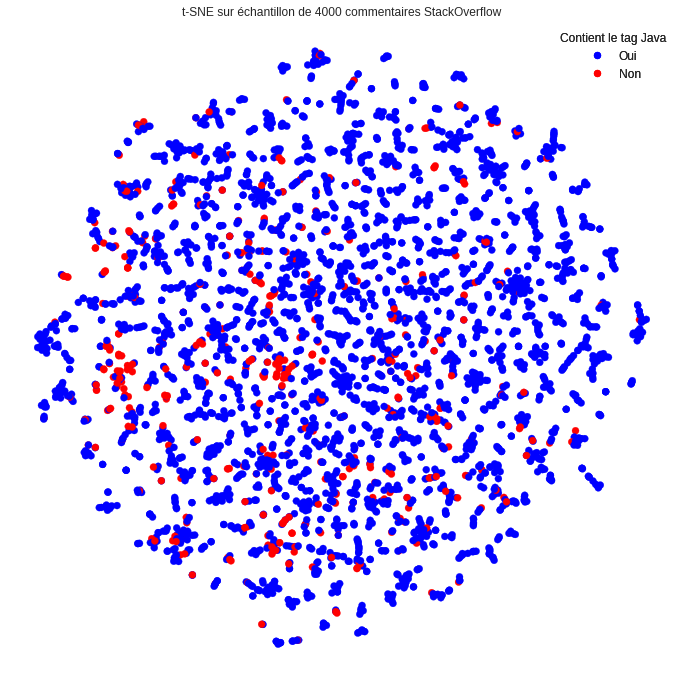

In [ ]:
# Java
fig, ax = plt.subplots(figsize=(12, 12))

scatter = ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.bwr, alpha=1, c=df.contain_java[:4000])

legend = ax.legend(handles=scatter.legend_elements()[0], fontsize="medium", labels=["Oui", "Non"], loc="upper right")
legend.set_title("Contient le tag Java") 
ax.add_artist(legend)
plt.title("t-SNE sur échantillon de 4000 commentaires StackOverflow")
ax.axis('off')

### Visualisation tag: Python

(-104.72211608886718,
 107.74764404296874,
 -103.52552909851075,
 100.05690879821778)

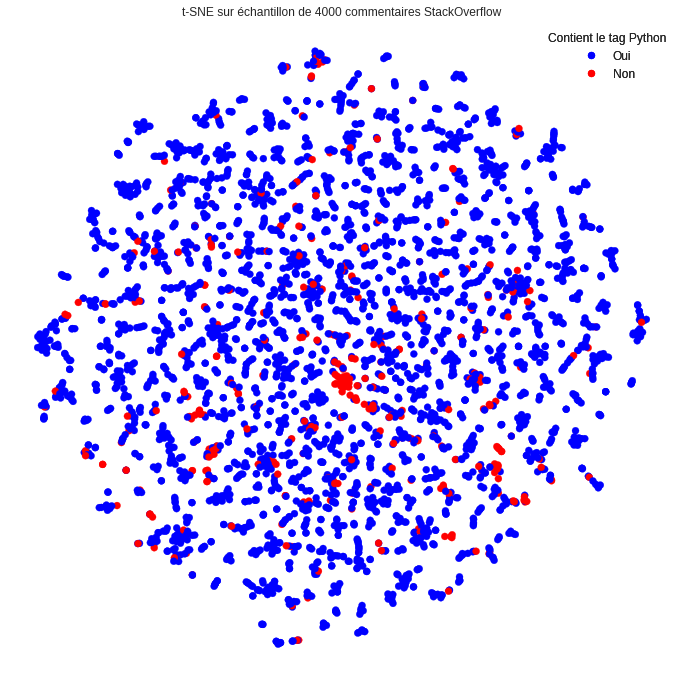

In [ ]:
# python
fig, ax = plt.subplots(figsize=(12, 12))

scatter = ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.bwr, alpha=1, c=df.contain_python[:4000])

legend = ax.legend(handles=scatter.legend_elements()[0], fontsize="medium", labels=["Oui", "Non"], loc="upper right")
legend.set_title("Contient le tag Python") 
ax.add_artist(legend)
plt.title("t-SNE sur échantillon de 4000 commentaires StackOverflow")
ax.axis('off')

### Visualisation tag: C sharp

(-104.72211608886718,
 107.74764404296874,
 -103.52552909851075,
 100.05690879821778)

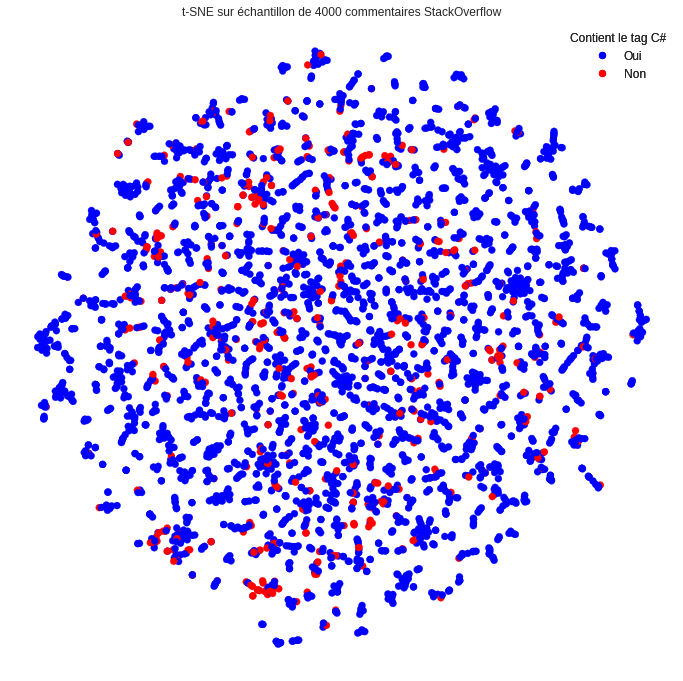

In [ ]:
# C#
fig, ax = plt.subplots(figsize=(12, 12))

scatter = ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.bwr, alpha=1, c=df.contain_csharp[:4000])

legend = ax.legend(handles=scatter.legend_elements()[0], fontsize="medium", labels=["Oui", "Non"], loc="upper right")
legend.set_title("Contient le tag C#") 
ax.add_artist(legend)
plt.title("t-SNE sur échantillon de 4000 commentaires StackOverflow")
ax.axis('off')

Visualisons maintenant pour un tags moins commun:

### Visualisation tag: SQL

(-104.72211608886718,
 107.74764404296874,
 -103.52552909851075,
 100.05690879821778)

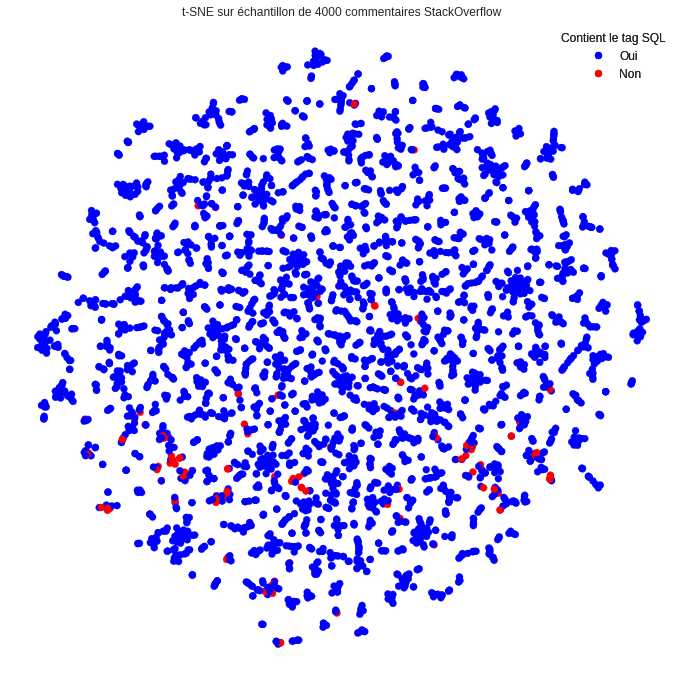

In [ ]:
# SQL
fig, ax = plt.subplots(figsize=(12, 12))

scatter = ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.bwr, alpha=1, c=df.contain_sql[:4000])

legend = ax.legend(handles=scatter.legend_elements()[0], fontsize="medium", labels=["Oui", "Non"], loc="upper right")
legend.set_title("Contient le tag SQL") 
ax.add_artist(legend)
plt.title("t-SNE sur échantillon de 4000 commentaires StackOverflow")
ax.axis('off')

## Conclusion des méthodes de réduction dimentionnelles


Qu'il s'agisse de tags plus ou moins communs, on ne constate pas de séparabilité/groupement après réduction à 2 dimentions avec t-SNE. 

**Aucune des 2 methodes de réduction dimentionnelle n'offre de résultats satisfaisants**. Cela n'est pas suprenant étant donné "l'overlapping" des tags (dans notre échantillon une même question a au minimum 5 tags différents).